## Adagrad
这个优化算法被称为自适应学习率优化算法，之前我们讲的随机梯度下降以及动量法对所有的参数都使用的固定的学习率进行参数更新，但是不同的参数梯度可能不一样，所以需要不同的学习率才能比较好的进行训练，但是这个事情又不能很好地被人为操作，所以 Adagrad 便能够帮助我们做这件事。

### Adagrad算法
Adagrad 的想法非常简答，在每次使用一个 batch size 的数据进行参数更新的时候，我们需要计算所有参数的梯度，那么其想法就是对于每个参数，初始化一个变量 s 为 0，然后每次将该参数的梯度平方求和累加到这个变量 s 上，然后在更新这个参数的时候，学习率就变为

$$
\frac{\eta}{\sqrt{s + \epsilon}}
$$
这里的 $\epsilon$ 是为了数值稳定性而加上的，因为有可能 s 的值为 0，那么 0 出现在分母就会出现无穷大的情况，通常 $\epsilon$ 取 $10^{-10}$，这样不同的参数由于梯度不同，他们对应的 s 大小也就不同，所以上面的公式得到的学习率也就不同，这也就实现了自适应的学习率。

Adagrad 的核心想法就是，如果一个参数的梯度一直都非常大，那么其对应的学习率就变小一点，防止震荡，而一个参数的梯度一直都非常小，那么这个参数的学习率就变大一点，使得其能够更快地更新

Adagrad 也有一些问题，因为 s 不断累加梯度的平方，所以会越来越大，导致学习率在后期会变得较小，导致收敛乏力的情况，可能无法收敛到表较好的结果，当然后面有一个对其的改进，我们之后会讲到

下面我们来实现一下 Adagrad 的算法

In [1]:
def sgd_adagrad(parameters, sqrs, lr):
    eps = 1e-10
    for param, sqr in zip(parameters, sqrs): #打包 一一对应
        sqr[:] = sqr + param.grad.data ** 2 #深复制
        div = lr / torch.sqrt(sqr + eps) * param.grad.data
        param.data = param.data - div

In [2]:
import numpy as np
import torch
from torchvision.datasets import MNIST # 导入 pytorch 内置的 mnist 数据
from torch.utils.data import DataLoader
from torch import nn
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
%matplotlib inline

def data_tf(x):
    x = np.array(x, dtype='float32') / 255
    x = (x - 0.5) / 0.5 # 标准化，这个技巧之后会讲到
    x = x.reshape((-1,)) # 拉平
    x = torch.from_numpy(x)
    return x

train_set = MNIST('./data', train=True, transform=data_tf, download=True) # 载入数据集，申明定义的数据变换
test_set = MNIST('./data', train=False, transform=data_tf, download=True)

# 定义 loss 函数
criterion = nn.CrossEntropyLoss()

In [3]:

train_data = DataLoader(train_set, batch_size=64, shuffle=True)
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
)

# 初始化梯度平方项
sqrs = []
for param in net.parameters():
    sqrs.append(torch.zeros_like(param.data))
    
# 开始训练
losses = []
idx = 0
start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        net.zero_grad()
        loss.backward()
        sgd_adagrad(net.parameters(), sqrs, 1e-2) # 学习率设为 0.01
        # 记录误差
        train_loss += loss.item()
        if idx % 30 == 0:
            losses.append(loss.item())
        idx += 1
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.422488
epoch: 1, Train Loss: 0.297307
epoch: 2, Train Loss: 0.268565
epoch: 3, Train Loss: 0.247701
epoch: 4, Train Loss: 0.231102
使用时间: 34.68326 s


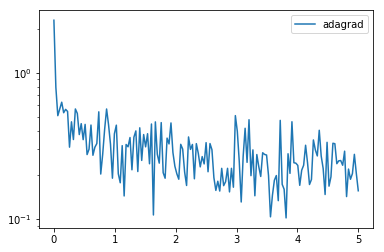

In [4]:
x_axis = np.linspace(0, 5, len(losses), endpoint=True)
plt.semilogy(x_axis, losses, label='adagrad')
plt.legend(loc='best')

当然 pytorch 也内置了 adagrad 的优化算法，只需要调用 torch.optim.Adagrad() 就可以了，下面是例子

In [9]:
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
# 使用 Sequential 定义 3 层神经网络

net = nn.Sequential(
    nn.Linear(784 , 100),
    nn.ReLU(),
    nn.Linear(100, 10),
)

optimizer = torch.optim.Adagrad(net.parameters(),lr=1e-2)

start = time.time()
for e in range(5):
    train_loss = 0
    for im,label in train_data:
        im = Variable(im)
        label = Variable(label)
        #向前传播
        out = net(im)
        loss = criterion(out,label)
        #反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    print ('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.423578
epoch: 1, Train Loss: 0.291298
epoch: 2, Train Loss: 0.257268
epoch: 3, Train Loss: 0.233255
epoch: 4, Train Loss: 0.215878
使用时间: 32.06227 s


## RMSProp
RMSprop 是由 Geoff Hinton 在他 Coursera 课程中提出的一种适应性学习率方法，至今仍未被公开发表。前面我们提到了 Adagrad 算法有一个问题，就是学习率分母上的变量 s 不断被累加增大，最后会导致学习率除以一个比较大的数之后变得非常小，这不利于我们找到最后的最优解，所以 RMSProp 的提出就是为了解决这个问题。

### RMSProp 算法
RMSProp 仍然会使用梯度的平方量，不同于 Adagrad，其会使用一个指数加权移动平均来计算这个 s，也就是

$$
s_i = \alpha s_{i-1} + (1 - \alpha) \ g^2
$$
这里 g 表示当前求出的参数梯度，然后最终更新和 Adagrad 是一样的，学习率变成了

$$
\frac{\eta}{\sqrt{s + \epsilon}}
$$
这里 $\alpha$ 是一个移动平均的系数，也是因为这个系数，导致了 RMSProp 和 Adagrad 不同的地方，这个系数使得 RMSProp 更新到后期累加的梯度平方较小，从而保证 s 不会太大，也就使得模型后期依然能够找到比较优的结果

pytorch 也内置了 rmsprop 的方法，非常简单，只需要调用 torch.optim.RMSprop() 就可以了，下面是例子

In [10]:
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
# 使用 Sequential 定义 3 层神经网络
net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
)

optimizer = torch.optim.RMSprop(net.parameters(), lr=1e-3, alpha=0.9)
    
# 开始训练

start = time.time() # 记时开始
for e in range(5):
    train_loss = 0
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.item()
    print('epoch: {}, Train Loss: {:.6f}'
          .format(e, train_loss / len(train_data)))
end = time.time() # 计时结束
print('使用时间: {:.5f} s'.format(end - start))

epoch: 0, Train Loss: 0.367702
epoch: 1, Train Loss: 0.168220
epoch: 2, Train Loss: 0.122506
epoch: 3, Train Loss: 0.104202
epoch: 4, Train Loss: 0.089248
使用时间: 47.12001 s
